# Segundo Projecto CRC 

## Imports

In [161]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from networkx.drawing.nx_pydot import write_dot
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics.pairwise import euclidean_distances

## Pre-Process

In [185]:
def handle_binary_column(df, att):
    label_encoder = LabelEncoder()
    #df[att] = label_encoder.fit_transform(df[att])
    return df


def handle_numeric_column(df, att):
    min_max_scaler = MinMaxScaler()
    df[att] = df[att].astype(float)
    df[att] = min_max_scaler.fit_transform(df[[att]])
    return df


def handle_na_column_mean(df, att):
    df[att] = pd.to_numeric(df[att], errors='ignore')
    mean_df = df[att].dropna().mean()
    df[att] = df[att].fillna(mean_df)
    return df


def handle_na_column_median(df, att):
    median = df[att].dropna().median()
    df[att] = df[att].fillna(median)
    return df


def handle_na_column_mode(df, att):
    mode = df[att].dropna().mode()[0]
    df[att] = df[att].fillna(mode)
    return df


def drop_column_na(df):
    return df.loc[:, df.isnull().mean() < .90]


def pre_process_data(df, handle_na, classes=[]):
    for att in df.columns:
        if df[att].isnull().sum().sum() != 0 and att not in classes:
            df = handle_na(df, att)
        if att not in classes:
            df = handle_numeric_column(df, att)
        if att == 'dx':
            df = handle_binary_column(df, att)
    return df

def pre_process(training, method):
    new_df = pre_process_data(training, method, classes=['subjectid', 'dx'])

    return new_df


def pre_process_drop(training, method):
    new_df = pre_process_data(drop_column_na(training), method, classes=['subjectid', 'dx'])

    return new_df

In [186]:
df = pd.read_csv('joined_data.csv', sep="," ,error_bad_lines=False, low_memory=False)

drop_cols = []

for i, row in df.dtypes.iteritems():
    if row == object and i!= 'subjectid' and i!='dx':
        drop_cols.append(i)

df_medic = df.drop(drop_cols, axis=1)
df_medic_0 = df_medic.copy()



df_medic_mean = pre_process_drop(df_medic_0, handle_na_column_median)
df_medic_mean.to_csv("processed_medic.csv")
print(df_medic_mean.shape)

c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

(1293, 607)


### Similarity

In [195]:
medic_mean_drop = pd.read_csv('processed_medic.csv')

y = medic_mean_drop['dx']
ids = medic_mean_drop['subjectid']

medic_mean_drop = medic_mean_drop.drop(['Unnamed: 0'], axis=1).drop(['subjectid'], axis=1).drop(['dx'], axis=1)

medic_mean_drop_new = SelectKBest(chi2, k=100).fit_transform(medic_mean_drop , y)

cos_similarity = cosine_similarity(medic_mean_drop_new)
euclidean_similarity = euclidean_distances(medic_mean_drop_new)

In [196]:
def build_adjacency_matrix(data_frame, distance_metric, threshold=2):
    
    distances = distance_metric(data_frame)
    size = len(distances)
    size_temp = 0
    temp_value = 0
    adj_matrix = np.zeros(shape=(size, size))
    
    for row in range(size):
        size_temp = len(distances[row])
        for value in range(size_temp):
            temp_value = distances[row][value]
            if temp_value > 0 and temp_value  <= threshold:
                adj_matrix[row][value] = 1
            else:
                continue
    return np.matrix(adj_matrix)

In [287]:
def create_attributes(disorder, subjectID):
    dis = {}
    s_id={}
    size = len(disorder)
    
    for i in range(size):
        s_id[i] = subjectID[i]
        dis[i] = disorder[i]
    return s_id, dis

In [289]:
matrix = build_adjacency_matrix(medic_mean_drop_new, euclidean_distances, 1)

G = nx.from_numpy_matrix(matrix)

s_ids, disorders = create_attributes(y,ids)

nx.set_node_attributes(G, 'subjectID', s_ids)
nx.set_node_attributes(G, 'disorder', disorders)

In [290]:
#pos = nx.nx_agraph.graphviz_layout(G)

write_dot(G, 'new.dot')

c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\networkx\drawing\nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\networkx\drawing\nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
c:\users\user\appdata\local\programs\python\python36-32\lib\site-packages\networkx\drawing\nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


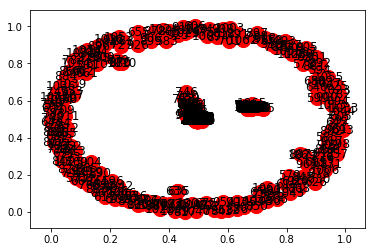

In [158]:
nx.draw_networkx(G,  with_labels=True, node_size = 200)
plt.savefig("simple_path.png") # save as png
plt.show() # display